In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
import re

warnings.filterwarnings("ignore")
np.random.seed(42)

In [3]:
# Configs
root = "./data/"
train_file = 'train.csv'
test_file = 'test.csv'
submit_file = 'submit.csv'
train_path = os.path.join(root, train_file)
test_path = os.path.join(root, test_file)
submit_path = os.path.join(root, submit_file)

In [4]:
# read data
df = pd.read_csv(train_path)
df.head(2)

,id,movie,dialogue,genres
0,0,0,I thought you were in a meeting--? <BR> I am. ...,"[u'drama', u'romance']"
1,1,1,Are you sure you're okay? You're pale. <BR> I...,[u'drama']


In [5]:
print(f"Shape of train data: {df.shape}")
df.isnull().sum()

Shape of train data: (36991, 4)


id          0
movie       0
dialogue    0
genres      0
dtype: int64

In [6]:
df.dtypes

id           int64
movie        int64
dialogue    object
genres      object
dtype: object

In [7]:
df_test = pd.read_csv(test_path)
#df_test['dialogue'] = df_test['dialogue'].apply(text_lower)

In [8]:
tags = set()
for i in range(df.shape[0]):
    row_tags = re.findall("<(?:\/)?\w+>", df['dialogue'][i])
    tags.update(row_tags)

In [9]:
def del_tags(row, tags=tags):
    for tag in tags:
        row = re.sub(tag, " ", row)
    return row

In [10]:
def clean_text_df(df):
    df['dialogue'] = df['dialogue'].apply(del_tags)
    return df

In [11]:
df = clean_text_df(df)
df_test = clean_text_df(df_test)

In [12]:
# change dtype of genres to list
correct_target = lambda x: x.split("'")[1:-1:2]
df['correct_genres'] = df['genres'].apply(correct_target)
df.drop(columns=['genres'], inplace=True)

In [13]:
# get all classes

classes = set()
i = 0
for row in df['correct_genres'].values:
    set_row = set(row)
    classes.update(set_row)
    i += 1
    
class_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_class = {idx: cls for idx, cls in enumerate(classes)}

for key, value in class_idx.items():
    assert class_idx[key] != idx_class[value]

In [14]:
# split the data
df_train, df_val = train_test_split(df, test_size=0.3, random_state=42)
df_train.shape, df_val.shape

((25893, 4), (11098, 4))

In [15]:
train_texts = df_train['dialogue'].values
val_texts = df_val['dialogue'].values
test_texts = df_test['dialogue'].values
stop_words_nltk = stopwords.words('english')
num_features = 10_000
ngram_range = (1, 1)

In [16]:
# build tfid train and val features
def build_features(train_texts=train_texts, 
                   val_texts=val_texts,
                   test_texts=test_texts,
                   num_features=num_features, 
                   max_df=0.5, 
                   stop_words=stop_words_nltk,
                   ngram_range = ngram_range,
                   lowercase=True):
    
    vectorizer = TfidfVectorizer(max_df = max_df, 
                                 max_features=num_features, 
                                 stop_words=stop_words, 
                                 ngram_range=ngram_range)
    
    train_features = vectorizer.fit_transform(train_texts)
    val_features = vectorizer.transform(val_texts)
    test_features = vectorizer.transform(test_texts)
    return train_features, val_features, test_features

In [35]:
train_features, val_features, test_features = build_features(num_features=20_000)
train_features.shape, val_features.shape, test_features.shape

((25893, 20000), (11098, 20000), (9403, 20000))

In [18]:
# get one hot target
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_train["correct_genres"])
y_train = multilabel_binarizer.transform(df_train["correct_genres"])
y_val = multilabel_binarizer.transform(df_val["correct_genres"])

In [19]:
def plot_hist(y):
    """
    y.shape = (num_objects, num_classes)
    """
    counts = y.sum(axis=0)/y.shape[0]
    sort_idx = np.argsort(counts)[::-1]
    sort_counts = [counts[idx] for idx in sort_idx]
    genres = [multilabel_binarizer.classes_[idx] for idx in sort_idx]
    
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(y = genres, x = sort_counts)
    ax.set(xlabel="Count", ylabel="Genre")
    plt.show()

In [20]:
plt.style.use("dark_background")

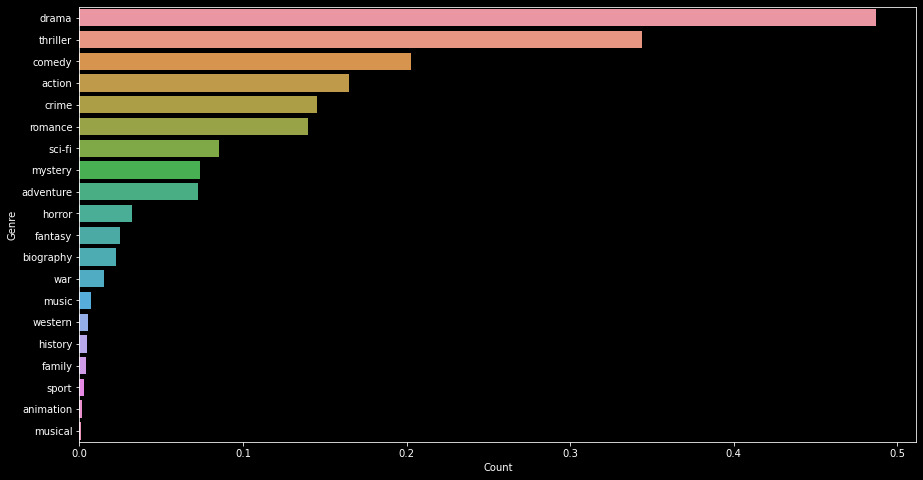

In [21]:
plot_hist(y_train)

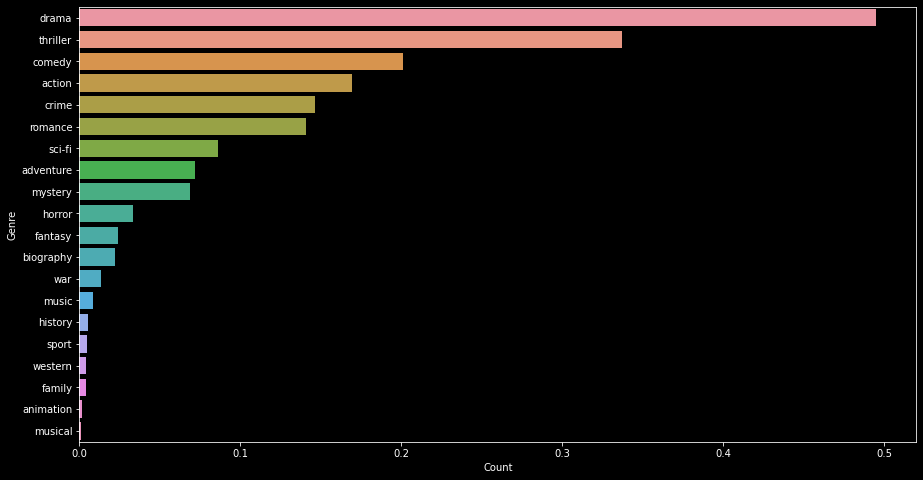

In [22]:
plot_hist(y_val)

In [36]:
def print_score(y_pred, y_val, clf):
    print("Clf: ", clf.__class__.__name__)
    score = f1_score(y_val, y_pred, average="samples") * 100
    print(f"f1 loss: {score:.3} %")
    print("---")

In [37]:
def fit_classifier(clf, train_features, y_train, classifier, threshold=0.25):
    clf.fit(train_features, y_train)
    y_pred = clf.predict_proba(val_features)
    y_pred = (y_pred >= threshold).astype(int)
    print_score(y_pred, y_val, classifier)
    return y_pred

In [38]:
classifier = LogisticRegression(C=1.0, random_state=9, n_jobs=-1)
clf = OneVsRestClassifier(classifier)
y_pred = fit_classifier(clf, train_features, y_train, classifier, threshold=0.3)

Clf:  LogisticRegression
f1 loss: 64.7 %
---


In [39]:
y_pred_test = clf.predict_proba(test_features)
y_pred_test = (y_pred_test >= 0.3).astype(int)

In [45]:
result = []
genres = np.array(multilabel_binarizer.classes_)
for i in range(len(y_pred_test)):
    result.append(" ".join(genres[np.where(y_pred_test[i]==1)]))

In [46]:
df_test = df_test.drop(columns = 'dialogue')
df_test['genres'] = result